# Tensorflow with GPU - Convolutional Neural Network

In [1]:
import numpy as np

import tensorflow as tf

print(f"TensorFlow version= {tf.__version__}")
print(f"CUDA available= {tf.test.gpu_device_name()}")

# CUDA Installation
print("CUDA Version")
! nvcc --version
print()

# Check CUDA TensorFlow
tf.test.is_built_with_cuda()

2023-12-29 00:57:15.500968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 00:57:15.501008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 00:57:15.501583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 00:57:15.504988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 00:57:16.005581: W tensorflow/compiler/tf2

TensorFlow version= 2.15.0
CUDA available= /device:GPU:0
CUDA Version
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0



2023-12-29 00:57:16.483691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:57:16.512532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:57:16.512565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:57:16.671141: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:57:16.671179: I external/local_xla/xla/stream_executor

True

In [2]:
import cv2
import sys
import os.path

IMGSIZE = (128, 128)
CNAMES = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
_path = "EP_datasets/images"

X_tr, y_tr, X_ts, y_ts = [], [], [], []
for label in CNAMES:
    path = _path + "/seg_train/seg_train/" + label
    for f in sorted([_ for _ in os.listdir(path) if _.lower().endswith(".jpg")]):
        X_tr += [cv2.resize(cv2.imread(os.path.join(path, f)), IMGSIZE)]
        y_tr += [CNAMES.index(label)]
    path = _path + "/seg_test/seg_test/" + label
    for f in sorted([_ for _ in os.listdir(path) if _.lower().endswith(".jpg")]):
        X_ts += [cv2.resize(cv2.imread(os.path.join(path, f)), IMGSIZE)]
        y_ts += [CNAMES.index(label)]

In [3]:
print(len(X_tr))
print(X_tr[0].shape)
print(len(y_tr))

print(len(X_ts))
print(X_ts[0].shape)
print(len(y_ts))

14034
(128, 128, 3)
14034
3000
(128, 128, 3)
3000


(-0.5, 127.5, 127.5, -0.5)

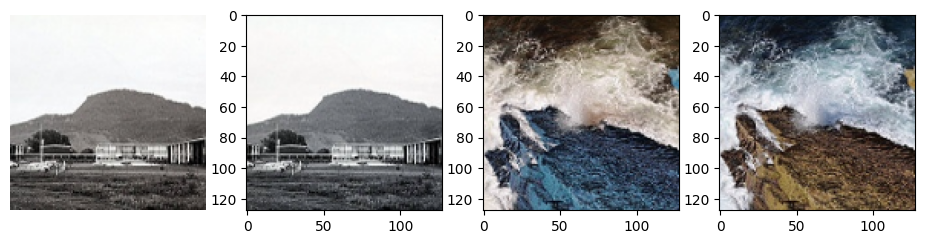

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 30))
rgb_img = cv2.cvtColor(X_tr[0], cv2.COLOR_BGR2RGB)
rgb_img2 = cv2.cvtColor(X_tr[10000], cv2.COLOR_BGR2RGB)
ax = fig.add_subplot(10, 10, 1)
ax2 = fig.add_subplot(10, 10, 2)
ax3 = fig.add_subplot(10, 10, 3)
ax4 = fig.add_subplot(10, 10, 4)
ax.imshow(rgb_img)
ax2.imshow(X_tr[0])
ax3.imshow(X_tr[10000])
ax4.imshow(rgb_img2)
ax.axis("off")

In [5]:
X_tr_np = np.asarray(X_tr)
X_ts_np = np.asarray(X_ts)

X_tr_np = X_tr_np.astype("float32")
X_ts_np = X_ts_np.astype("float32")

X_tr_np /= 255.0
X_ts_np /= 255.0

print(X_tr_np[0].max())
print(X_tr_np[0].min())

1.0
0.0


In [6]:
y_tr_np = np.asarray(y_tr)
y_ts_np = np.asarray(y_ts)

y_tr_np = y_tr_np.astype("uint8")
y_ts_np = y_ts_np.astype("uint8")

In [7]:
# Clear session
tf.keras.backend.clear_session()

# Our full CNN neural network
cnn1 = tf.keras.Sequential()

cnn1.add(
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(5, 5),
        data_format="channels_last",
        name="conv_1",
        activation="relu",
    )
)

cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_1"))

cnn1.add(
    tf.keras.layers.Conv2D(
        filters=20, kernel_size=(5, 5), name="conv_2", activation="relu"
    )
)

cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_2"))

cnn1.add(tf.keras.layers.Flatten())

cnn1.add(tf.keras.layers.Dense(units=512, name="fc_1", activation="relu"))

cnn1.add(tf.keras.layers.Dense(units=6, name="fc_2", activation="softmax"))

# Set a seed for repeatibility
tf.random.set_seed(0)

# Build the model
cnn1.build(input_shape=(None, 128, 128, 3))

# Compile the model with the optimizer, loss function and metric
cnn1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

NUM_EPOCHS = 10

2023-12-29 00:57:23.934567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:57:23.934640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:57:23.934662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:57:23.934783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:57:23.934805: I external/local_xla/xla/stream_executor

In [8]:
%%time
history = cnn1.fit(X_tr_np, y_tr_np, epochs=NUM_EPOCHS, shuffle=True)

2023-12-29 00:57:25.401190: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2759196672 exceeds 10% of free system memory.
2023-12-29 00:57:26.405652: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2759196672 exceeds 10% of free system memory.


Epoch 1/10


2023-12-29 00:57:27.823194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-29 00:57:28.411598: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f80d43408c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-29 00:57:28.411631: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-12-29 00:57:28.423172: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703836648.509922   30963 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 [==============================] - 5s 7ms/step - loss: 0.9565 - accuracy: 0.6295
Epoch 2/10
439/439 [==============================] - 2s 6ms/step - loss: 0.6193 - accuracy: 0.7721
Epoch 3/10
439/439 [==============================] - 2s 6ms/step - loss: 0.4092 - accuracy: 0.8498
Epoch 4/10
439/439 [==============================] - 3s 6ms/step - loss: 0.2476 - accuracy: 0.9130
Epoch 5/10
439/439 [==============================] - 3s 6ms/step - loss: 0.1568 - accuracy: 0.9472
Epoch 6/10
439/439 [==============================] - 3s 6ms/step - loss: 0.0803 - accuracy: 0.9758
Epoch 7/10
439/439 [==============================] - 2s 6ms/step - loss: 0.0744 - accuracy: 0.9772
Epoch 8/10
439/439 [==============================] - 2s 6ms/step - loss: 0.0612 - accuracy: 0.9827
Epoch 9/10
439/439 [==============================] - 3s 6ms/step - loss: 0.0482 - accuracy: 0.9869
Epoch 10/10
439/439 [==============================] - 3s 6ms/step - loss: 0.0412 - accuracy: 0.9890
CPU times:

In [9]:
# Testing dataset
y_pred = np.argmax(cnn1.predict(X_ts_np), axis=1)

print(f"Accuracy= {sum(y_pred==y_ts_np)/len(X_ts_np):.3f}")

2023-12-29 00:57:55.857969: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 589824000 exceeds 10% of free system memory.
2023-12-29 00:57:56.081440: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 589824000 exceeds 10% of free system memory.


94/94 [==============================] - 0s 3ms/step
Accuracy= 0.742


In [10]:
# Clear session
tf.keras.backend.clear_session()

# Our full CNN neural network
cnn2 = tf.keras.Sequential()

cnn2.add(
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(5, 5),
        data_format="channels_last",
        name="conv_1",
        activation="relu",
    )
)
cnn2.add(tf.keras.layers.Dropout(0.2))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_1"))

cnn2.add(
    tf.keras.layers.Conv2D(
        filters=20, kernel_size=(5, 5), name="conv_2", activation="relu"
    )
)
cnn2.add(tf.keras.layers.Dropout(0.2))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_2"))

cnn2.add(tf.keras.layers.Flatten())

cnn2.add(tf.keras.layers.Dense(units=512, name="fc_1", activation="relu"))
cnn2.add(tf.keras.layers.Dropout(0.2))

cnn2.add(tf.keras.layers.Dense(units=6, name="fc_2", activation="softmax"))

# Set a seed for repeatibility
tf.random.set_seed(0)

# Build the model
cnn2.build(input_shape=(None, 128, 128, 3))

# Compile the model with the optimizer, loss function and metric
cnn2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

NUM_EPOCHS = 10

history2 = cnn2.fit(X_tr_np, y_tr_np, epochs=NUM_EPOCHS, shuffle=True)

# Testing dataset
y_pred2 = np.argmax(cnn2.predict(X_ts_np), axis=1)

print(f"Accuracy= {sum(y_pred2==y_ts_np)/len(X_ts_np):.3f}")

2023-12-29 00:57:57.684257: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2759196672 exceeds 10% of free system memory.


Epoch 1/10


2023-12-29 00:58:00.367686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


439/439 [==============================] - 5s 7ms/step - loss: 1.0567 - accuracy: 0.5949
Epoch 2/10
439/439 [==============================] - 3s 7ms/step - loss: 0.7891 - accuracy: 0.7007
Epoch 3/10
439/439 [==============================] - 3s 7ms/step - loss: 0.5907 - accuracy: 0.7836
Epoch 4/10
439/439 [==============================] - 3s 7ms/step - loss: 0.4094 - accuracy: 0.8525
Epoch 5/10
439/439 [==============================] - 3s 7ms/step - loss: 0.2693 - accuracy: 0.9061
Epoch 6/10
439/439 [==============================] - 3s 7ms/step - loss: 0.2025 - accuracy: 0.9297
Epoch 7/10
439/439 [==============================] - 3s 7ms/step - loss: 0.1354 - accuracy: 0.9545
Epoch 8/10
439/439 [==============================] - 3s 7ms/step - loss: 0.1145 - accuracy: 0.9622
Epoch 9/10
439/439 [==============================] - 3s 7ms/step - loss: 0.0867 - accuracy: 0.9708
Epoch 10/10
94/94 [==============================] - 0s 3ms/step
Accuracy= 0.743
